In [1]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from tqdm import tqdm

from dare import Riccati
from device import device
from env_setup import *
from human import HumanRobotEnv
from models import ThetaEstimatorMLP

Did not find GPU


In [2]:
#@title Simulate how human updates the internal model

# totaol simulation steps
sim_time = 20
n_demo   = 1

human_mode = 'gradient_decent'
#human_mode = 'gradient_decent_threshold'

# store the training data
robot_state_all_demo        = []
human_action_all_demo       = []
human_obs_all_demo          = []
human_mental_state_all_demo = []
for i in range(n_demo):
    human_env = HumanRobotEnv('passive_teaching', 1.0, 'use_model_human', True)
    human_env.set_environment(A, B, Q, R, None, None, sim_time)
    human_env.set_action_set(None, u_t0_R_aug_set)
    human_env.set_human_internal_model(None)
    
    # Initialize the robot state [0.4; 0], human mental state [1.0] (human thinks B[1,0]=1.0)
    human_env.set_human_state(np.array([[5.0], [2.0]]), np.array([[1.0]]))
    human_env.noisy_human = False
    for i in range(sim_time):
        # print(i)
        human_env.step(None)
    #print('One demo gathered!')
    
    robot_state_all_demo.append(human_env.current_demo_state_traj)
    human_action_all_demo.append(human_env.current_demo_human_action_traj)
    human_obs_all_demo.append(human_env.current_demo_human_obs_traj)
    human_mental_state_all_demo.append(human_env.current_demo_human_mental_state_traj)

print('Trajectories: {}'.format(n_demo))

Trajectories: 1


### Visualize the simulated human trajectory

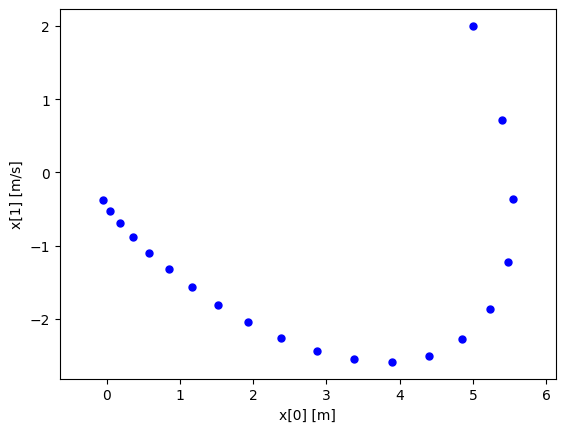

The robot starts at 0.4 m with 0 speed. Its goal is to achieve [0;0]. Note that the robot decelerates first, then accelerates


In [3]:
#@title Visualize the simulated human trajectory
human_traj = np.array(human_env.current_demo_state_traj).squeeze()
plt.plot(human_traj[:,0],human_traj[:,1],'bo', markersize=5)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.axis('equal')
plt.xlabel('x[0] [m]')
plt.ylabel('x[1] [m/s]')
plt.show()
print('The robot starts at 0.4 m with 0 speed. Its goal is to achieve [0;0]. \
Note that the robot decelerates first, then accelerates')

### Visualize the simulated human internal model

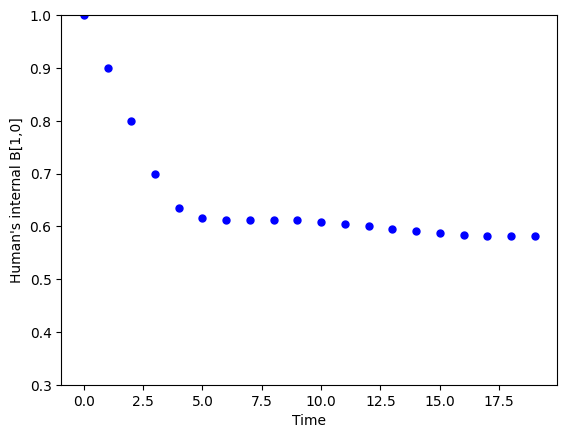

Note that here human's estination of B[1,0] starts from 1.0, then slowly approaches to the correct value (0.5).


In [4]:
#@title Visualize the simulated human internal model
human_internal_state_traj = np.array(human_env.current_demo_human_mental_state_traj).squeeze()
plt.plot(human_internal_state_traj, 'bo', markersize=5)
plt.ylim([0.3, 1.0])
plt.xlabel('Time')
plt.ylabel('Human\'s internal B[1,0]')
plt.show()
print('Note that here human\'s estination of B[1,0] starts from 1.0, then slowly approaches to the correct value (0.5).')

### Pre-processing trajectory data for estimator

In [5]:
# Assemble data into matrix
states = [s[0].T for s in robot_state_all_demo[0]]
states = np.concatenate(states)

actions = [a[0].T for a in human_action_all_demo[0]]
actions = np.concatenate(actions)

mental_states = [s[0].T for s in human_mental_state_all_demo[0]]
mental_states = np.concatenate(mental_states)
mental_states = torch.tensor(mental_states).to(device)

sa_tuples = np.concatenate((states, actions), axis=1)

# Create normalizer
scaler = StandardScaler()
scaler.fit(sa_tuples)
norm_sa_tuples = scaler.transform(sa_tuples)

# Put inputs into tensors
sa_tuples = torch.tensor(sa_tuples).to(device)
norm_sa_tuples = torch.tensor(norm_sa_tuples).to(device)
states = sa_tuples[:, :2]
actions = sa_tuples[:, 2:]
norm_states = norm_sa_tuples[:, :2]
norm_actions = norm_sa_tuples[:, 2:]

N = states.shape[0]
print(N)

20


In [11]:
states = torch.tensor(robot_state_all_demo, device=device)
states = states.view(n_demo * sim_time, nX)

actions = torch.tensor(human_action_all_demo, device=device)
actions = actions.view(n_demo * sim_time, nU)

inputs = torch.cat((states, actions), axis=1)
inputs = inputs.view(n_demo, sim_time, nX + nU).float()
print(inputs.shape)

torch.Size([1, 20, 3])


In [29]:
class ThetaEstimatorTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        d_model = 3
        self.transformer_encoder = nn.TransformerEncoderLayer(d_model=d_model, nhead=3, batch_first=True)
        self.linear_relus = nn.Sequential(
            nn.Linear(d_model, 3),
            nn.ReLU(),
            nn.Linear(3, 3),
            nn.ReLU(),
            nn.Linear(3, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        _, layers, _ = x.size()
        mask = torch.zeros(layers, layers, dtype=torch.bool)
        for i in range(layers):
            for j in range(i+1):
                mask[i, j] = True
        mask = mask.to(device)

        y = self.transformer_encoder(x, src_mask=mask)
        y = self.linear_relus(y)
        return y

model = ThetaEstimatorTransformer()
out = model(inputs)
print(out.shape)

"""
Questions:
1) Do we want to positionally encode each (s, a) in the trajectory?
2) How to compute one hidden state (i.e. a scalar) for each trajectory?
3) Transformer takes whole trajectory but LQR takes only one (s, a) pair
4) Is the mask correct (i.e. a lower triangular matrix)?
"""

torch.Size([1, 20, 1])


### Train $\theta_H$ estimator E2E with LQR

In [10]:
EPOCHS = 50
theta_H_estimator = ThetaEstimatorMLP().to(device).double()
theta_H_estimator.train()
optimizer = torch.optim.Adam(theta_H_estimator.parameters(), lr=0.1)

In [11]:
def step(state, action, norm_state, norm_action):
    input = torch.cat((norm_state, norm_action)).reshape(-1)
    # theta_H = theta_H_estimator(input)
    theta_H = torch.clamp(theta_H_estimator(input), min=0.001, max=1.0)
    # theta_H = theta_H * 0 + 1.0
    B_hat_tensor = (theta_H[0]) * torch.tensor([[0., ],[1.0]], device = device).double()
    P_hat = Riccati.apply(A_tensor, B_hat_tensor, Q_tensor, R_tensor)

    K = torch.chain_matmul(
        torch.linalg.pinv(torch.add(
            R_tensor,
            torch.chain_matmul(torch.transpose(B_hat_tensor, 0, 1), P_hat, B_hat_tensor)
        )),
        torch.transpose(B_hat_tensor, 0, 1),
        P_hat,
        A_tensor
    )
    action_pred = torch.neg(torch.matmul(K, state))

    optimizer.zero_grad()
    loss_fn = nn.MSELoss()
    # loss = torch.norm(action_pred - action)
    loss = loss_fn(action_pred, action)
    loss.backward()
    optimizer.step()

    # action_dist = torch.norm(action_pred - action)
    # print('Epoch: Loss={}, theta_H={}, action_pred={}, action={}, action_dist={}'.format(loss.data.item(), theta_H.data.item(), action_pred.data.item(), action.data.item(), action_dist.data.item()))
    # print('Epoch: Loss={}, theta_H={}'.format(loss.data.item(), theta_H.data.item()))

    return loss.data.item(), theta_H.data.item()

100%|██████████| 50/50 [00:01<00:00, 30.93it/s]


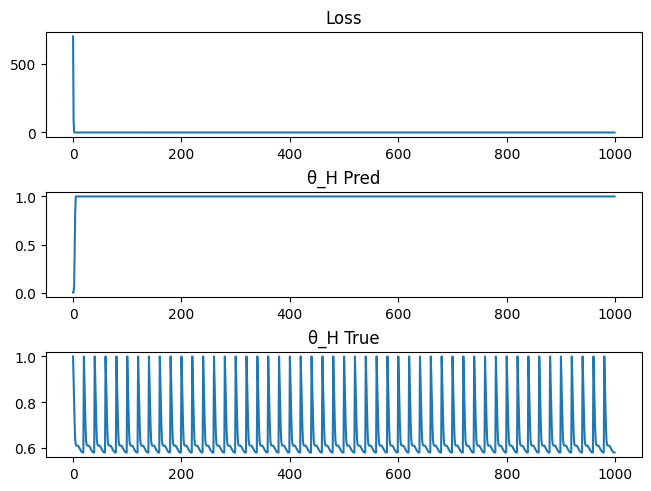

In [12]:
loss_list, theta_H_list, theta_H_true_list = [], [], []
for epoch in tqdm(range(EPOCHS)):
    for idx in range(N):
        # idx = randrange(N)
        # idx = 0
        state, action, mental_state = states[idx], actions[idx], mental_states[idx]
        norm_state, norm_action = norm_states[idx], norm_actions[idx]
        loss, theta_H = step(state, action, norm_state, norm_action)
        loss_list.append(loss)
        theta_H_list.append(theta_H)
        theta_H_true_list.append(mental_state.data.item())
    # print('Epoch {}: Loss={}, theta_H={}'.format(epoch, loss, theta_H))

fig, axs = plt.subplots(3, constrained_layout=True)
axs[0].plot(range(EPOCHS * N), loss_list)
axs[1].plot(range(EPOCHS * N), theta_H_list)
axs[2].plot(range(EPOCHS * N), theta_H_true_list)
axs[0].title.set_text('Loss')
axs[1].title.set_text('θ_H Pred')
axs[2].title.set_text('θ_H True')